# LiDAR Uncertainty at two NEON Field Sites
## Soaproot Saddle (SOAP) Field Site
![Soaproot Saddle Field Site](img/Soaproot_pano.jpeg)
Image Credit: National Ecological Oberservatory Network, https://www.neonscience.org/field-sites/soap

## San Joaquin Experimental Range (SJER) Field Site 
![SJER Field Site](img/SJER_pano.jpeg)
Image Credit: National Ecological Observatory Network, https://www.neonscience.org/field-sites/sjer

In [1]:
# Import packages
import os
import pathlib

import earthpy as et
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterstats as rs
import xarray as xr
import rioxarray as rxr
import seaborn as sns

# Get lidar data
et.data.get_data('spatial-vector-lidar')

# Set working directory
working_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'spatial-vector-lidar')

# Check working directory exists, create directory if does not exist
if not os.path.exists(working_dir):
    print('Path does not exist. Creating...')
    os.makedirs(working_dir)
os.chdir(working_dir)

# Check working directory path is correct
print(working_dir)


Extracted output to /Users/jen/earth-analytics/data/spatial-vector-lidar/.
/Users/jen/earth-analytics/data/spatial-vector-lidar


In [2]:
class NEONDataLoader:
    """
    Parent class to load NEON tree height data.
    """

    base_dir_tmpl = os.path.join(
        'california',
        'neon-{site_name_low}-site')

    insitu_path_tmpl = os.path.join(
        '{base_dir}',
        '2013',
        'insitu',
        'veg{separator}structure',
        'D17_2013_{site_name_up}_vegStr.csv')

    chm_path_tmpl = os.path.join(
        '{base_dir}',
        '2013',
        'lidar',
        '{site_name_up}_lidarCHM.tif')

    plots_path_tmpl = os.path.join(
        '{base_dir}',
        'vector_data',
        '{site_name_up}{plot}_centroids.shp')

    site_name = NotImplemented
    id_col_name = NotImplemented
    formatting_dict = NotImplemented
    id_mod = None
    
    def __init__(self):
        self.formatting_dict = self.formatting_dict
        self.formatting_dict['site_name_low'] = self.site_name.lower()
        self.formatting_dict['site_name_up'] = self.site_name.upper()
        self.formatting_dict['base_dir'] = (
            self.base_dir_tmpl.format(**self.formatting_dict))

        self.insitu_path = self.insitu_path_tmpl.format(**self.formatting_dict)
        self.chm_path = self.chm_path_tmpl.format(**self.formatting_dict)
        self.plots_path = self.plots_path_tmpl.format(**self.formatting_dict)

        self._insitu_height_stats = None
        self._lidar_chm_stats = None
        self._height_stats = None

    @property
    def lidar_chm_stats(self):
        """
        Calculate max, mean tree height from LiDAR data.
        """
        if self._lidar_chm_stats is None:
            plots_gdf = gpd.read_file(self.plots_path)
            plots_gdf.geometry = plots_gdf.geometry.buffer(20)

            # Calculate Zonal statistics
            chm_stats = rs.zonal_stats(
                plots_gdf,
                self.chm_path,
                stats=['mean', 'max'],
                geojson_out=True,
                nodata=0,
                copy_properties=True)

            # Create GeoDataFrame
            self._lidar_chm_stats = gpd.GeoDataFrame.from_features(chm_stats)

            # Rename GeoDataFram columns
            self._lidar_chm_stats.rename(
                columns={'max':'lidar_max', 'mean':'lidar_mean'},
                inplace=True)
            if not self.id_mod is None:
                self._lidar_chm_stats[self.id_col_name] = (
                    self._lidar_chm_stats[self.id_col_name]
                    .apply(self.id_mod))
        return self._lidar_chm_stats
    
    @property
    def insitu_height_stats(self):
        """ 
        Load and calculate insitu max and mean tree height data.
        """
        if self._insitu_height_stats is None:
            self._insitu_height_stats = (
                pd.read_csv(self.insitu_path)
                .groupby('plotid')
                .stemheight
                .agg(['max', 'mean'])
                .rename(columns={'max': 'insitu_max', 'mean': 'insitu_mean'}))
        return self._insitu_height_stats
    
    @property
    def height_stats(self):
        """
        Merge insitu data with LiDar data.
        """
        if self._height_stats is None:
            self._height_stats = (
                self.lidar_chm_stats
                .merge(
                    self.insitu_height_stats, 
                    right_index=True, 
                    left_on=self.id_col_name))
        return self._height_stats

In [3]:
class SJERDataLoader(NEONDataLoader):

    site_name = 'SJER'
    id_col_name = 'Plot_ID'
    formatting_dict = {'separator': '_', 'plot': '_plot'}

sjer_data_loader = SJERDataLoader()
sjer_gdf = sjer_data_loader.height_stats
sjer_gdf

,geometry,Plot_ID,Point,northing,easting,plot_type,lidar_max,lidar_mean,insitu_max,insitu_mean
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544347,19.3,3.866667
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277,23.9,8.221429
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398,16.0,8.218750
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675346,11.0,6.512500
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591177,8.8,7.600000
5,"POLYGON ((257098.867 4111388.570, 257098.771 4...",SJER128,center,4111388.570,257078.867,trees,19.139999,8.987087,18.2,5.211765
6,"POLYGON ((256703.434 4111071.087, 256703.338 4...",SJER192,center,4111071.087,256683.434,grass,16.549999,7.229096,13.7,6.769565
7,"POLYGON ((256737.467 4112167.778, 256737.371 4...",SJER272,center,4112167.778,256717.467,trees,11.840000,7.107061,12.4,6.819048
8,"POLYGON ((256054.390 4111533.879, 256054.294 4...",SJER2796,center,4111533.879,256034.390,soil,20.279999,6.409630,9.4,5.085714
9,"POLYGON ((258517.102 4109856.983, 258517.006 4...",SJER3239,center,4109856.983,258497.102,soil,12.910000,6.009128,17.9,3.920833


In [4]:
class SOAPDataLoader(NEONDataLoader):

    site_name = 'SOAP'
    id_col_name = 'ID'
    formatting_dict = {'separator': '-', 'plot': ''}

    def id_mod(self, id):
        """ Adds site name to plot number in ID column."""
    
        return 'SOAP' + str(id)

soap_data_loader = SOAPDataLoader()
soap_gdf = soap_data_loader.height_stats
soap_gdf

,geometry,OBJECTID,ID,plotType,subtype,plotDimens,Protocols,lidar_max,lidar_mean,insitu_max,insitu_mean
1,"POLYGON ((297065.197 4100713.028, 297065.101 4...",2,SOAP43,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",54.099998,19.804080,51.1,5.047000
2,"POLYGON ((299825.197 4101013.028, 299825.101 4...",3,SOAP63,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",32.480000,16.989834,33.0,9.232787
4,"POLYGON ((298715.197 4100833.028, 298715.101 4...",5,SOAP95,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",33.869999,17.412048,28.1,6.050943
5,"POLYGON ((297065.197 4100083.028, 297065.101 4...",6,SOAP139,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",49.919998,19.417840,120.0,4.745902
6,"POLYGON ((299885.197 4100413.028, 299885.101 4...",7,SOAP143,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",27.340000,10.454653,19.7,2.530702
7,"POLYGON ((297545.197 4100533.028, 297545.101 4...",8,SOAP187,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",47.959999,13.221389,134.0,4.878947
9,"POLYGON ((297515.197 4100683.028, 297515.101 4...",10,SOAP299,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",34.189999,18.852112,33.1,13.896154
10,"POLYGON ((297065.197 4100593.028, 297065.101 4...",11,SOAP331,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",45.500000,18.149803,39.2,5.009848
22,"POLYGON ((299315.197 4101463.028, 299315.101 4...",23,SOAP223,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",13.469999,6.155488,8.2,2.444186
23,"POLYGON ((297785.197 4101193.028, 297785.101 4...",24,SOAP283,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",19.369999,5.781789,13.8,3.328571


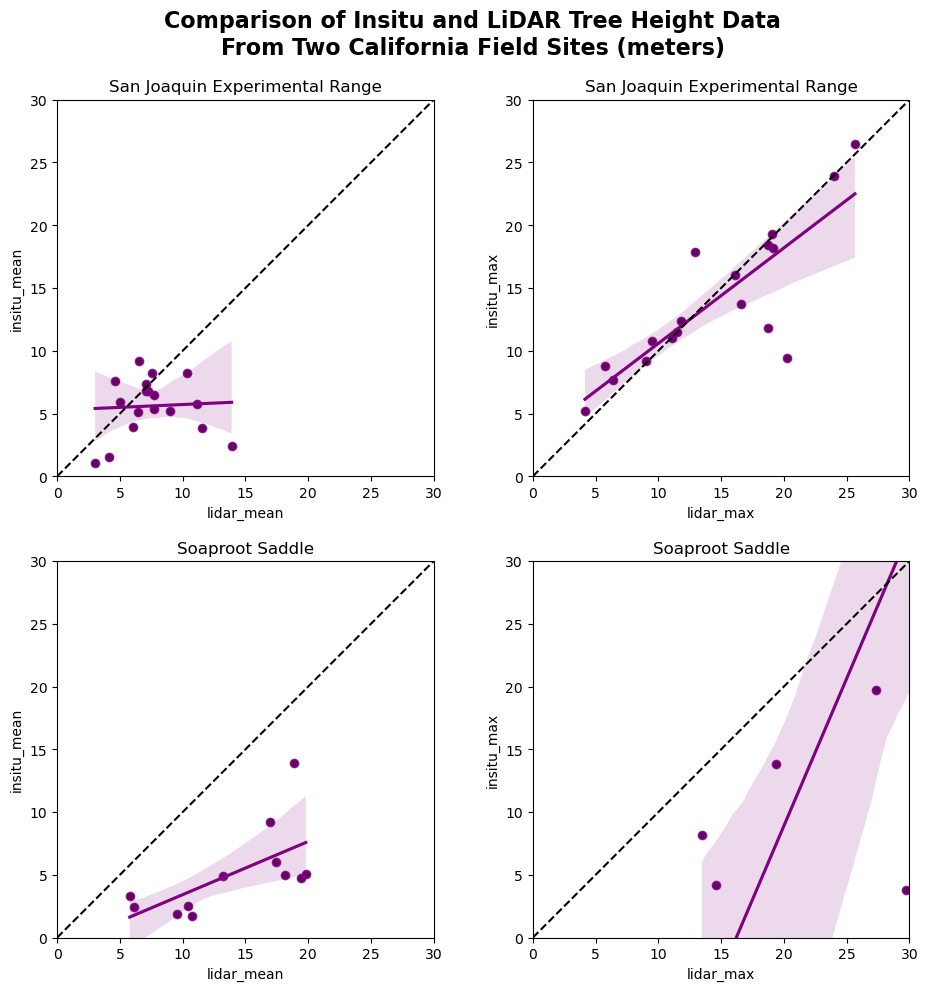

In [5]:
def plot_height_stats(height_stats_gdf, axs, site, aggr):
    """
    Plot of Insitu and LiDAR tree height max and means.
    ----------
    Parameters:
    height_stats_gdf: GeoPandasDataFrame 
        GeoPandasDataFrame with LiDAR and insitu tree height statistics.
    
    axs: figure ax
        Ax figure to add to plot.
    
    site: str
        Site Name.
    
    aggr: str
        Aggregation statistic to plot (mean or max)
    -------
    Returns: 
    plot_height_stats: Plot of tree height statistics.
    """
    # Set limits and aspect of plot
    axs.set(xlim=(0, 30), ylim=(0, 30), aspect='equal')
    
    # Define plot type and columns to plot
    sns.scatterplot(
        x='lidar_{aggr}'.format(aggr=aggr),
        y='insitu_{aggr}'.format(aggr=aggr),
        data=height_stats_gdf, color='black',ax=axs)

    # Plot regression
    sns.regplot(
        x='lidar_{aggr}'.format(aggr=aggr),
        y='insitu_{aggr}'.format(aggr=aggr),
        data=height_stats_gdf, color='purple', ax=axs)

    # Set plot title labels
    axs.set_title(site)

    # Plot 1:1 line
    axs.plot(
        (0, 1), (0, 1), 
        transform=axs.transAxes, 
        ls='--', c='k')
    return plot_height_stats

# Plot Insitu vs LiDAR Tree Height Data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
plt.suptitle(
    'Comparison of Insitu and LiDAR Tree Height Data\n'
    'From Two California Field Sites (meters)',
    fontweight='bold',
    fontsize=16)
plt.tight_layout(pad=2, h_pad=4, w_pad=0.5)

plot_height_stats(sjer_gdf, ax1, 'San Joaquin Experimental Range', 'mean')
plot_height_stats(sjer_gdf, ax2, 'San Joaquin Experimental Range', 'max')
plot_height_stats(soap_gdf, ax3, 'Soaproot Saddle', 'mean')
plot_height_stats(soap_gdf, ax4, 'Soaproot Saddle', 'max')

plt.show()

